# Dense Neural Network Poker Hand

INSTITUTO FEDERAL DE MINAS GERIAS Departamento de Engenharia e Computação

Professor: Ciniro Nametala

Aluno: Euler Gomes

Dataset: https://archive.ics.uci.edu/dataset/158/poker+hand

# 1. Ambient preparation

In [1]:
from IPython.display import display, HTML
from tensorflow.python.layers.core import dense

display(HTML("<style>.container {widht: 100% !important;}</style>"))

## 1.1. Import packages

In [2]:
import subprocess
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tabulate import tabulate
import progressbar
import pygame

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, LayerNormalization, BatchNormalization, Flatten, Dense, Reshape, Dropout

from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import BinaryCrossentropy

C:\Users\euler\miniconda3\envs\tf\lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


pygame 2.6.1 (SDL 2.28.4, Python 3.9.25)
Hello from the pygame community. https://www.pygame.org/contribute.html


## 1.2. Export requirements.txt

In [3]:
def export_requirements():
    try:
        result = subprocess.run([sys.executable, "-m", "pip", "freeze"],
                                capture_output=True,
                                text=True,
                                check=True)
        with open('requirements.txt', 'w') as f:
            f.write(result.stdout)
        print('requirements.txt file generated successfully.')
    except subprocess.CalledProcessError as e:
        print('error:', e)


export_requirements()

requirements.txt file generated successfully.


## 1.3. Gpu check

In [4]:
gpus = tf.config.list_physical_devices('GPU')
print(f"TensorFlow found GPUs: {len(gpus) > 0}")
print(f"TensorFlow GPU devices: {gpus}")

TensorFlow found GPUs: True
TensorFlow GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 1.4. Experiment configuration

In [5]:
#create a new model
new_model = True

use_complete_data = True

# 2. Load dataset

In [8]:
#load dataset
if use_complete_data:
    col_names = ['s1','c1', 's2', 'c2', 's3','c3', 's4', 'c4','s5', 'c5', 'class']
    data = pd.read_csv('data/poker-hand-testing.data', names=col_names)
else:
    data = pd.read_csv('data/poker_hand_dataset_minor.csv')
    col_names = data.columns.values.tolist()  #get columns names

x_names = data.columns[:-1].tolist()
y_names = data.columns[-1:].tolist()

data.head()

,s1,c1,s2,c2,s3,c3,s4,c4,s5,c5,class
0,1,1,1,13,2,4,2,3,1,12,0
1,3,12,3,2,3,11,4,5,2,5,1
2,1,9,4,6,1,4,3,2,3,9,1
3,1,4,3,13,2,13,2,1,3,6,1
4,3,10,2,7,1,2,2,11,4,9,0


# 3. Explore data

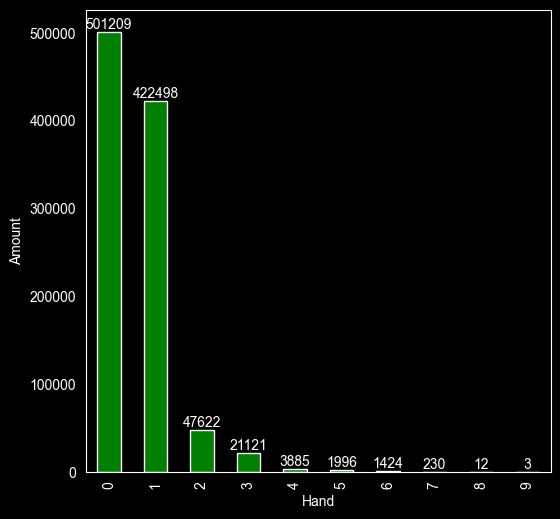

In [9]:
class_counts = data['class'].value_counts()  #count number of class

plt.figure(figsize=(6, 6))
class_counts.plot(kind="bar", color="green")
plt.xlabel("Hand")
plt.ylabel('Amount')
plt.grid(False)

for i, count in enumerate(class_counts):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=10)

plt.show()

## 3.1. Summarization

In [10]:
def summarization(data):
    stats = []

    for column in col_names[0:9]:
        values = data[column]

        maximum = round(values.max(), 2)
        minimum = round(values.min(), 2)
        mean = round(values.mean(), 2)
        median = round(values.median(), 2)
        std = round(values.std(), 2)

        stats.append([column, maximum, minimum, mean, median, std])

    headers = ['Column', 'Max', 'Min', 'Mena', 'Median', 'Std']

    table = tabulate(stats, headers, tablefmt="pipe")
    print(table)


summarization(data)

| Column   |   Max |   Min |   Mena |   Median |   Std |
|:---------|------:|------:|-------:|---------:|------:|
| s1       |     4 |     1 |   2.5  |        3 |  1.12 |
| c1       |    13 |     1 |   7    |        7 |  3.74 |
| s2       |     4 |     1 |   2.5  |        3 |  1.12 |
| c2       |    13 |     1 |   7.01 |        7 |  3.74 |
| s3       |     4 |     1 |   2.5  |        3 |  1.12 |
| c3       |    13 |     1 |   7    |        7 |  3.74 |
| s4       |     4 |     1 |   2.5  |        3 |  1.12 |
| c4       |    13 |     1 |   7    |        7 |  3.74 |
| s5       |     4 |     1 |   2.5  |        2 |  1.12 |


## 3.2. Separate x and y from data

In [11]:
#split x and y from data
x_raw = data.drop('class', axis=1)
y_raw = data['class']

# 4. Pre-processing I (One-Hot Encoding for inputs)

## 4.1. Separate  suits and cards

In [12]:
suits = x_raw[['s1', 's2', 's3', 's4', 's5']]
cards = x_raw[['c1', 'c2', 'c3', 'c4', 'c5']]

## 4.2. One-Hot for suits

In [13]:
ohe_suits = OneHotEncoder(sparse_output=False)
suits_encoded = ohe_suits.fit_transform(suits)

suits_encoded.shape

(1000000, 20)

## 4.3. One-Hot for cards

In [15]:
ohe_cards = OneHotEncoder(sparse_output=False)
cards_encoded = ohe_suits.fit_transform(cards)

cards_encoded.shape

(1000000, 65)

## 4.4. Concatenate both

In [16]:
x = np.hstack([suits_encoded, cards_encoded])
x.shape

(1000000, 85)

# 5. Pre-processing II (One-Hot Encoding for outputs)

In [17]:
y = tf.keras.utils.to_categorical(y_raw, num_classes=10)
y.shape

(1000000, 10)

# 6. Split dataset

In [18]:
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, shuffle=True, random_state=42, stratify=y_raw)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, shuffle=True, random_state=42)

x_train.shape, x_test.shape, x_val.shape

((700000, 85), (150000, 85), (150000, 85))

# 7. Model

## 7.1. Model class

In [19]:
#parameters
activation = 'relu'
drop = 0.1
learning_rate = 0.001

In [20]:
if use_complete_data:
    dnn_poker_hand = Sequential([
    Dense(128, activation=activation, input_shape=(85,)),
    Dropout(drop),
    Dense(128, activation=activation),
    Dropout(drop),
    Dense(64, activation=activation),
    Dropout(drop),
    Dense(10, activation='softmax')
])
else:
    dnn_poker_hand = Sequential([
        Dense(64, activation=activation, input_shape=(85,)),
        Dropout(drop),
        Dense(64, activation=activation),
        Dropout(drop),
        Dense(32, activation=activation),
        Dropout(drop),
        Dense(10, activation='softmax')
    ])

## 7.2. Model summary and plot

In [21]:
dnn_poker_hand.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               11008     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 10)                6

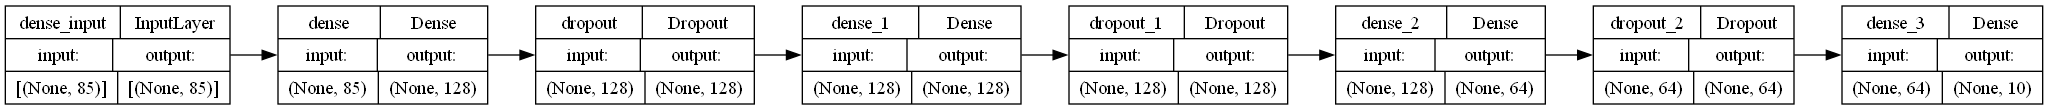

In [22]:
plot_model(dnn_poker_hand, show_shapes=True, show_layer_names=True, rankdir='LR')

## 7.3. Model compile

In [23]:
dnn_poker_hand.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 8. Optimizing model

In [24]:
if new_model:
    es = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    cp = ModelCheckpoint(filepath='models/best_poker_model.weights.h5',
                         save_weights_only=True,
                         monitor='loss',
                         mode='min',
                         save_best_only=True, )

    if use_complete_data:
        history = dnn_poker_hand.fit(
            x_train, y_train,
            validation_data=(x_val, y_val),
            epochs=30,
            batch_size=512,
            callbacks=[cp, es],
            verbose=1
        )
    else:
        history = dnn_poker_hand.fit(
            x_train, y_train,
            validation_data=(x_val, y_val),
            epochs=60,
            batch_size=128,
            callbacks=[cp, es],
            verbose=1
        )

    np.save('models/history_model.npy', history.history)
    dnn_poker_hand.load_weights('models/best_poker_model.weights.h5')
    dnn_poker_hand.save('models/best_poker_model.weights.h5')
else:
    dnn_poker_hand.load_weights('models/best_poker_model.weights.h5')

Epoch 1/30
1368/1368 [==============================] - 7s 3ms/step - loss: 0.6663 - accuracy: 0.7128 - val_loss: 0.1342 - val_accuracy: 0.9673
Epoch 2/30
1368/1368 [==============================] - 3s 2ms/step - loss: 0.2112 - accuracy: 0.9377 - val_loss: 0.0535 - val_accuracy: 0.9892
Epoch 3/30
1368/1368 [==============================] - 3s 2ms/step - loss: 0.1133 - accuracy: 0.9669 - val_loss: 0.0290 - val_accuracy: 0.9926
Epoch 4/30
1368/1368 [==============================] - 3s 2ms/step - loss: 0.0669 - accuracy: 0.9817 - val_loss: 0.0194 - val_accuracy: 0.9965
Epoch 5/30
1368/1368 [==============================] - 3s 2ms/step - loss: 0.0476 - accuracy: 0.9878 - val_loss: 0.0166 - val_accuracy: 0.9972
Epoch 6/30
1368/1368 [==============================] - 3s 2ms/step - loss: 0.0384 - accuracy: 0.9908 - val_loss: 0.0155 - val_accuracy: 0.9975
Epoch 7/30
1368/1368 [==============================] - 3s 2ms/step - loss: 0.0331 - accuracy: 0.9923 - val_loss: 0.0162 - val_accuracy:

In [25]:
pygame.mixer.init()
success_audio = 'support_files/mario_coin.mp3'
pygame.mixer.music.load(success_audio)
pygame.mixer.music.play()

while pygame.mixer.music.get_busy():
    continue

print('Success!')

Success!


# 9. Evaluating optimizing quality

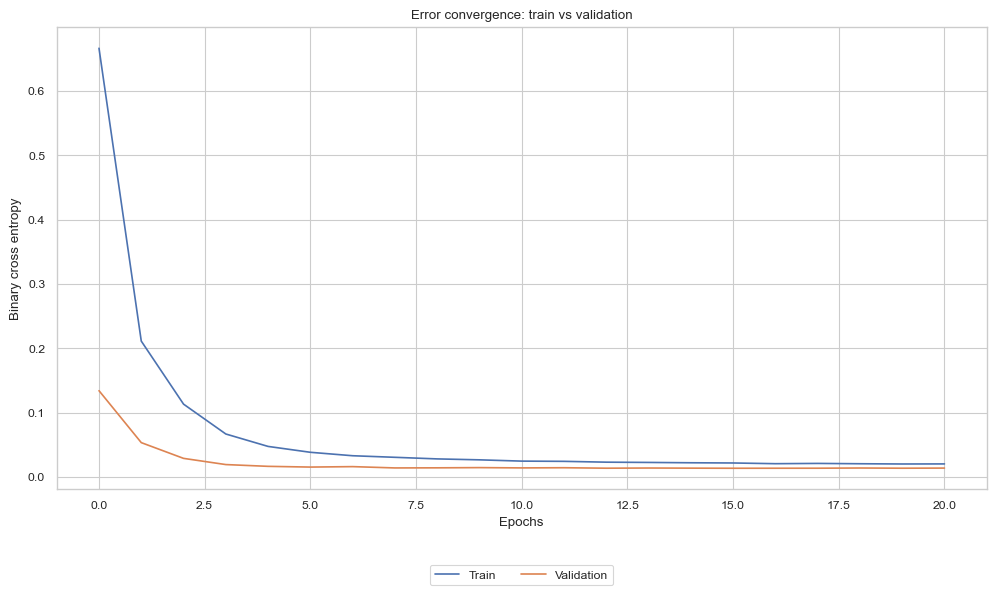

In [26]:
history = np.load('models/history_model.npy', allow_pickle='TRUE').item()

sns.set(rc={'figure.figsize': (12, 6)})
sns.set_style('whitegrid')
sns.set_context('paper')

train_metric = history['loss']
valid_metric = history['val_loss']
name_metric = 'Binary cross entropy'

fig = plt.figure()
plt.plot(train_metric, label='Train')
plt.plot(valid_metric, label='Validation')
plt.ylabel(name_metric)
plt.xlabel('Epochs')
plt.title('Error convergence: train vs validation')
plt.legend(loc='upper center', bbox_to_anchor = (0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

# 10. Model evaluate

In [27]:
loss, acc = dnn_poker_hand.evaluate(x_test, y_test)
print(f'Test loss: {loss:.3f}, Test accuracy: {acc:.3f}')

4688/4688 [==============================] - 6s 1ms/step - loss: 0.0132 - accuracy: 0.9980
Test loss: 0.013, Test accuracy: 0.998


# 11. Confusion matrix

In [28]:
y_hat = dnn_poker_hand.predict(x_test)
y_hat_classes = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_test, axis=1)
y_hat_classes

4688/4688 [==============================] - 3s 712us/step


array([1, 1, 0, ..., 0, 1, 1], dtype=int64)

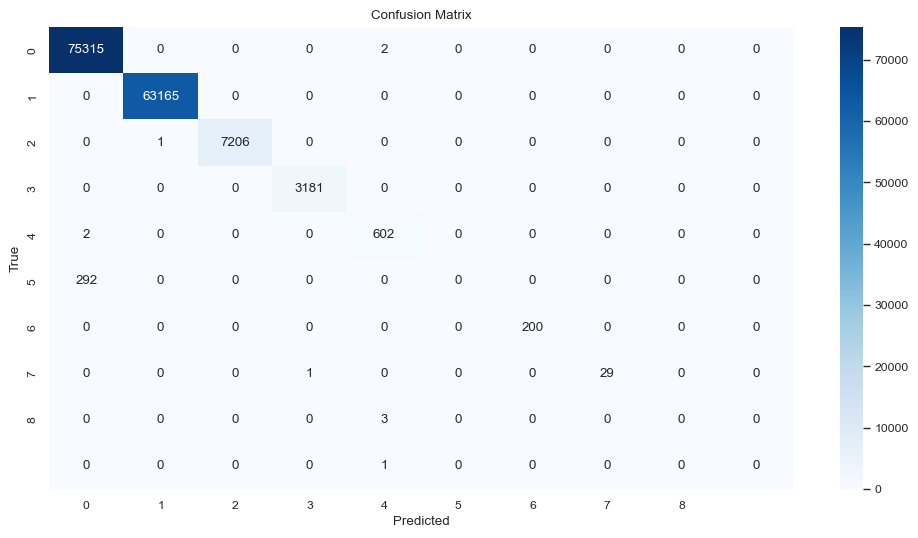

In [29]:
cm = confusion_matrix(y_true, y_hat_classes)

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap='Blues',
    xticklabels=[str(i) for i in range(9)],
    yticklabels=[str(i) for i in range(9)]
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()